In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob


In [35]:
def eofs_GA(inxarr, variables=['u','v'], neofs=10, time_name='time', treshold=None):
    tmp=inxarr[variables]
    tmp=tmp.to_stacked_array('z_loc',sample_dims=[time_name]).fillna(0)
    solver = Eof(tmp)

    out=solver.eofs(neofs=neofs).to_unstacked_dataset('z_loc').unstack()
    #xr.Dataset()
    out['X']=inxarr['X']
    out['Y']=inxarr['Y']
    out['time']=inxarr['time']
    out['eigenvals']=solver.eigenvalues()
    out['land_binary_mask']=inxarr['land_binary_mask']
    #if treshold < lmbda.mode.max(): 
    #    np.searchsorted(lmbda.cumsum()/lmbda.sum(),[0.9,],side='right')[0]
    # eofs=solver.eofs(neofs=5).to_unstacked_dataset('z_loc').unstack()
    # out['eofs_u']=eofs['u']
    # out['eofs_v']=eofs['v']
    out['speed']=np.sqrt(out.u**2+out.v**2)
    angles=np.arctan2(out['v'],out['u'])
    out['direction']=(angles + 2 * np.pi) % (2 * np.pi)*(180/np.pi)
    out['pcs']=solver.pcs(npcs=5)

    return out

    

In [10]:
def plot_eofs(res,name='',save_dir='',save=False):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.7)
    fig.suptitle("Eofs" + name, fontsize=18, y=0.95)
    axes=axs.ravel()
    res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time',ax=axes[0])
    (res.eigenvals[0:10].cumsum()/res.eigenvals.sum()).plot(marker='x',ax=axes[1])
    res.eigenvals[0:10].plot(marker='o',color='r',ax=axes[1].twinx())
    
    for mode in np.arange(4):
        res.isel(mode=mode).where(res.land_binary_mask==0).plot.quiver(x='X',y='Y' ,u='u', v='v',hue='u',ax=axes[mode+2])

    if save:
        plt.savefig(save_dir+name+'.jpg')

In [11]:
data=xr.open_dataset('byfjordenSubset.nc')

In [12]:
data.isel(depth=1)

<xarray.Dataset>
Dimensions:           (time: 1501, Y: 400, X: 201)
Coordinates:
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, Y, X) float32 ...
    v                 (time, Y, X) float32 ...
    h                 (Y, X) float32 ...
    projection_stere  float32 ...
    land_binary_mask  (Y, X) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [26]:
May=data.isel(time=data.time.dt.month.isin(5))

In [36]:
res=eofs_GA(May.isel(depth=1))
res['land_binary_mask']=May['land_binary_mask']
res

<xarray.Dataset>
Dimensions:           (mode: 10, Y: 400, X: 201, time: 418)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 9
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-05-01T00:53:20 ... 2010-05-3...
Data variables:
    u                 (mode, Y, X) float32 -1.132e-16 -1.021e-16 ... 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 23.84 17.63 12.06 ... 1.024 0.9748 0.9052
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 1.132e-16 1.021e-16 ... 0.0 0.0
    direction         (mode, Y, X) float32 180.0 180.0 180.0 ... 0.0 0.0 0.0
    pcs               (time, mode) float32 -4.489 -5.187 2.008 ... nan nan nan

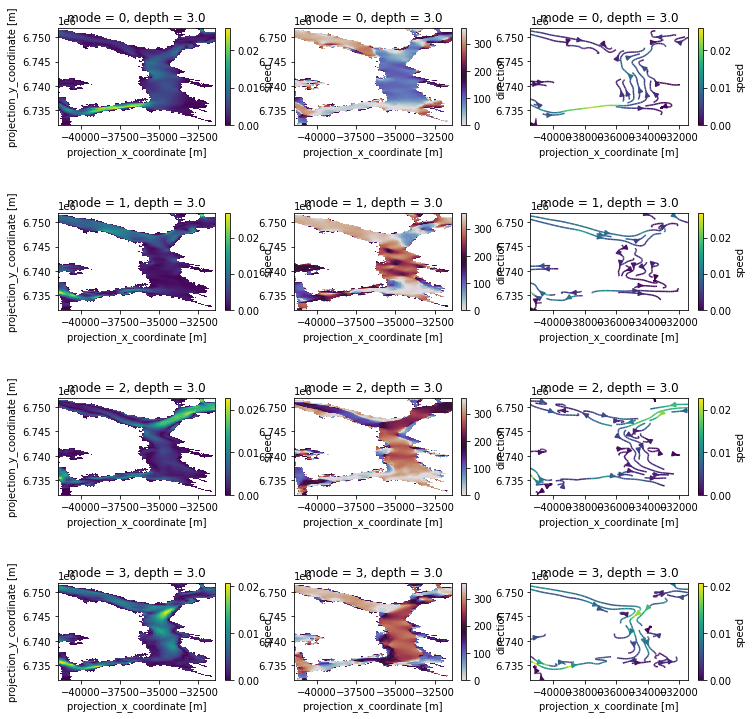

In [96]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
plt.subplots_adjust(hspace=0.9)
axes=axs.ravel()
for mode in np.arange(4):
    res['speed'].where(res.land_binary_mask==0).isel(mode=mode).plot(ax=axes[3*mode])
    
    res['direction'].where(res.land_binary_mask==0).isel(mode=mode).plot(cmap='twilight',ax=axes[3*mode+1])
    res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v',hue='speed',ax=axes[3*mode+2])
    axs[mode][1].set_ylabel('')
    axs[mode][2].set_ylabel('')


In [88]:
tmp=axs[1]


In [90]:
tmp[1]

<AxesSubplot:title={'center':'mode = 1, depth = 3.0'}, xlabel='projection_x_coordinate [m]', ylabel='projection_y_coordinate [m]'>

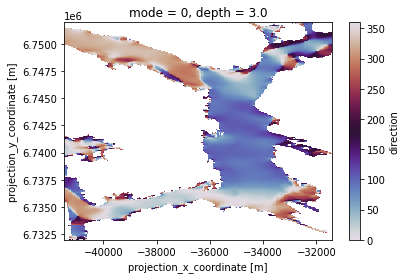

In [38]:
res['direction'].where(res.land_binary_mask==0).isel(mode=0).plot(cmap='twilight')

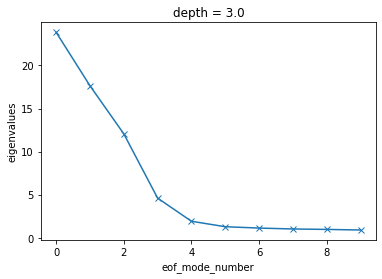

In [30]:
res.eigenvals.plot(marker='x')

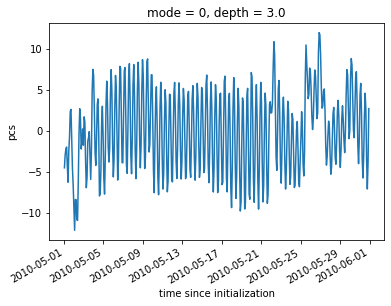

In [31]:
mode=0
res.pcs.isel(mode=mode).plot()

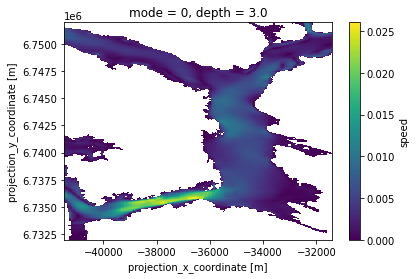

In [32]:

res.speed.where(res.land_binary_mask==0).isel(mode=mode).plot()

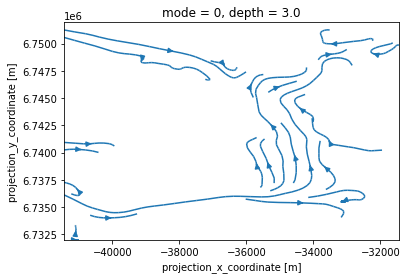

In [33]:
res.isel(mode=mode).where(res.land_binary_mask==0).plot.streamplot(x='X',y='Y' ,u='u', v='v')

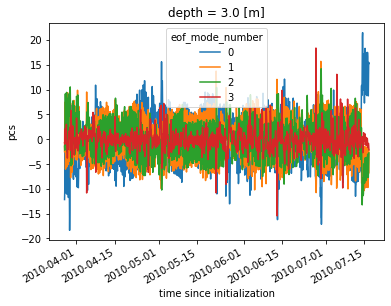

In [21]:
res.pcs.isel(mode=[0,1,2,3]).plot.line(x='time')

In [22]:
res

<xarray.Dataset>
Dimensions:           (mode: 10, Y: 400, X: 201, time: 1501)
Coordinates:
  * mode              (mode) int64 0 1 2 3 4 5 6 7 8 9
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
    depth             float32 3.0
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    v                 (mode, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    eigenvals         (mode) float32 28.59 19.41 14.78 ... 1.008 0.9224 0.8579
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    speed             (mode, Y, X) float32 2.214e-16 4.443e-16 ... 0.0 0.0
    direction         (mode, Y, X) float32 90.0 90.0 270.0 90.0 ... 0.0 0.0 0.0
    pcs               (time, mode) float32 -12.16 -2.491 -1.415 ... nan nan nan

(6735000.0, 6737500.0)

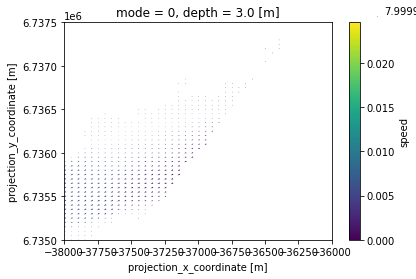

In [21]:
ix=98
iy=84
plt.clf()
res.isel(mode=mode).where(res.land_binary_mask==0).plot.quiver(x='X',y='Y' ,u='u', v='v',hue='speed')
plt.xlim(-38000,-36000)
plt.ylim(6735000,6737500)

In [44]:
res.time.diff(dim='time')/np.timedelta64(1, 'h')

<xarray.DataArray 'time' (time: 1500)>
array([1.77777778, 1.77777778, 1.77777778, ..., 1.77777778, 1.77777778,
       1.77777778])
Coordinates:
    depth    float32 3.0
  * time     (time) datetime64[ns] 2010-03-27T17:46:40 ... 2010-07-16T18:40:00

In [48]:
res.time

<xarray.DataArray 'time' (time: 1501)>
array(['2010-03-27T16:00:00.000000000', '2010-03-27T17:46:40.000000000',
       '2010-03-27T19:33:20.000000000', ..., '2010-07-16T15:06:40.000000000',
       '2010-07-16T16:53:20.000000000', '2010-07-16T18:40:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    depth    float32 3.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time

In [22]:
freq=res.time.diff(dim='time').mean()/np.timedelta64(1, 'h')
freq=1/freq
infreq=freq.values
infreq

array(0.5625)

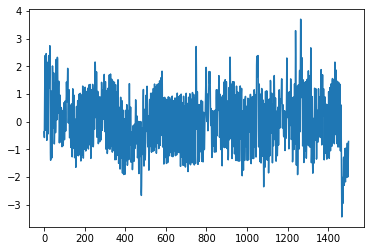

In [53]:
y=res.isel(mode=2).pcs.values
y=(y-np.mean(y))/np.std(y)
plt.plot(y)

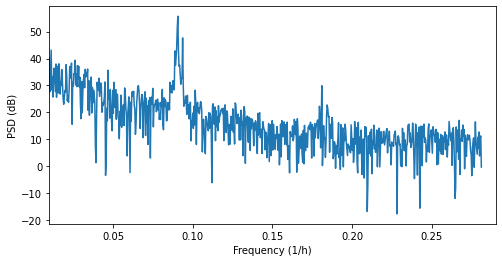

In [62]:

temp_fft = sp.fft.fft(y)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fft.fftfreq(len(temp_psd), 1/infreq)
i = fftfreq > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0.01, 0.29)
ax.set_xlabel('Frequency (1/h)')
ax.set_ylabel('PSD (dB)')
#%%
f=abs(np.fft.fft(y))

# get the list of frequencies
num=np.size(f)
freq = [i / num for i in list(range(num))]

# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
nspectrum=spectrum/spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
#plt.semilogy(nspectrum)

In [67]:
1/fftfreq[temp_psd.argmax()]

11.026629935720843

In [65]:
date2num(res.time)

array([14695.66666667, 14695.74074074, 14695.81481481, ...,
       14806.62962963, 14806.7037037 , 14806.77777778])

In [26]:

coef = solve(date2num(res.time), y, lat=60.0, method='robust',Rayleigh_min=0.9)#, constit=['M2'])#,nodal=True, rend=True, method='robust', conf_int='linear', Rayleigh_min=0.95)

tide = reconstruct(date2num(res.time), coef)

coef.keys()

solve: matrix prep ... solution ... done.
prep/calcs ... done.


dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'rf', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])

In [84]:
mode=0
ein=res.isel(mode=mode).direction.values.flatten()
ein

array([ 90.00001,  90.00001, 270.     , ...,   0.     ,   0.     ,
         0.     ], dtype=float32)

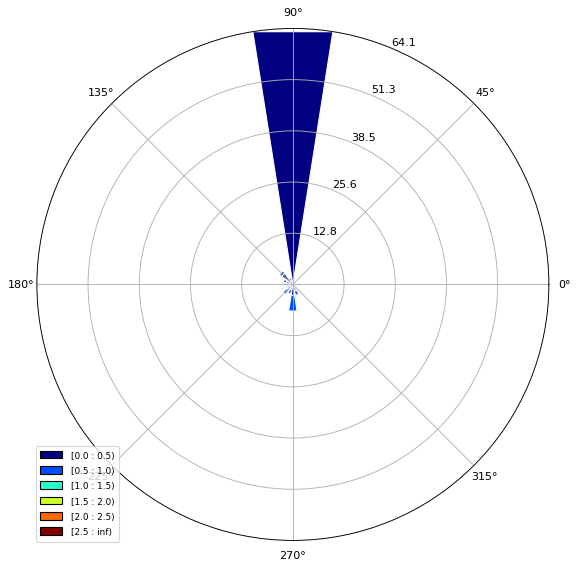

In [85]:

from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(res.isel(mode=mode).direction.values.flatten().squeeze(), 100*res.isel(mode=mode).speed.values.flatten(), normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

In [32]:
tide

{'t_in': array([14695.66666667, 14695.74074074, 14695.81481481, ...,
        14806.62962963, 14806.7037037 , 14806.77777778]),
 'epoch': 'python',
 'constit': None,
 'min_SNR': 2,
 'min_PE': 0,
 't_mpl': array([14695.66666667, 14695.74074074, 14695.81481481, ...,
        14806.62962963, 14806.7037037 , 14806.77777778]),
 'h': array([-0.53924914, -0.15554712,  0.05357926, ...,  0.86581091,
         1.49850673,  1.49079787])}

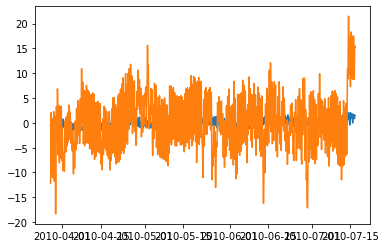

In [39]:
plt.plot(res.time,tide.h)
plt.plot(res.time,res.isel(mode=0).pcs)

In [35]:
tide

{'t_in': array([14695.66666667, 14695.74074074, 14695.81481481, ...,
        14806.62962963, 14806.7037037 , 14806.77777778]),
 'epoch': 'python',
 'constit': None,
 'min_SNR': 2,
 'min_PE': 0,
 't_mpl': array([14695.66666667, 14695.74074074, 14695.81481481, ...,
        14806.62962963, 14806.7037037 , 14806.77777778]),
 'h': array([-0.53924914, -0.15554712,  0.05357926, ...,  0.86581091,
         1.49850673,  1.49079787])}

Text(0.5, 1.0, 'Residue')

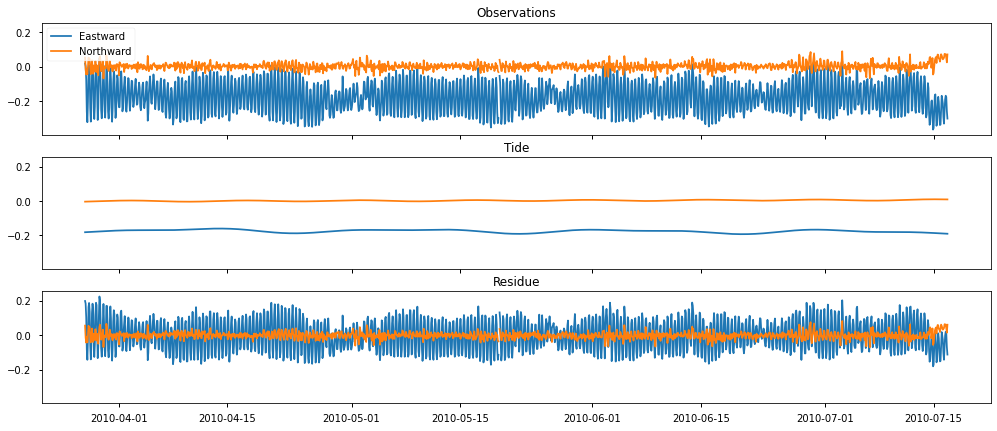

In [69]:
from matplotlib import style

style.use('seaborn-notebook')
t=tmpu.time
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True,  figsize=(17, 7))

ax0.plot(t, ein.u, label='Eastward')

ax0.legend(numpoints=1, loc='upper left')
ax0.set_title('Observations')


ax1.plot(t, tide['u'] )
ax1.plot(t, tide['v'])
ax1.set_title('Tide')
#ax1.legend(numpoints=1, loc='upper left')

ax2.plot(t, ein.u-tide['u'])
ax2.plot(t, ein.v-tide['v'])
ax2.set_title('Residue')

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
uu=ein.v.squeeze().to_dataframe().v

uu=uu.interpolate()
uu.index[1]-uu.index[0]

Timedelta('0 days 01:46:40')

In [21]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

In [71]:

decomposition = seasonal_decompose(uu, model='additive', period=220)


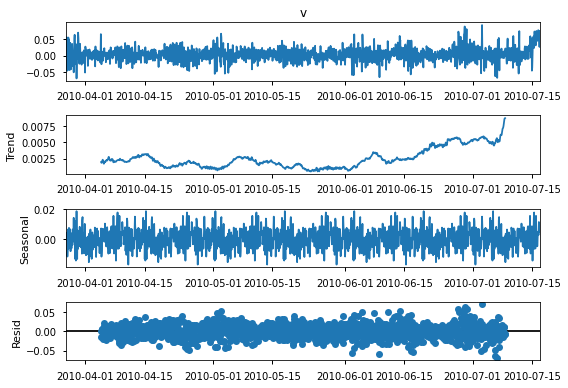

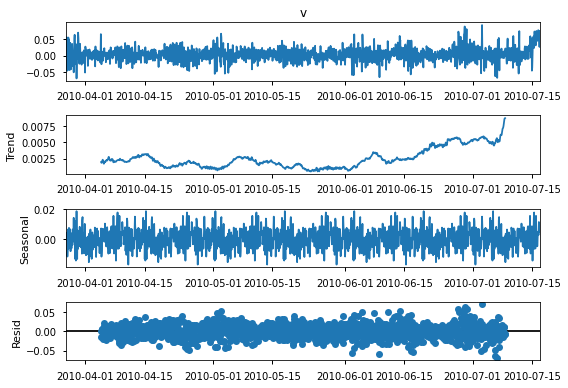

In [72]:
decomposition.plot()